# Effects of Covid-19 on Unemployment and the Economy
***
### - Correlation between Covid-19 and the S&P.
### - Correlation between Covid-19 and unemployment.
### - U.S. States that were affected the most.
### - Industries that were affected the most.
***
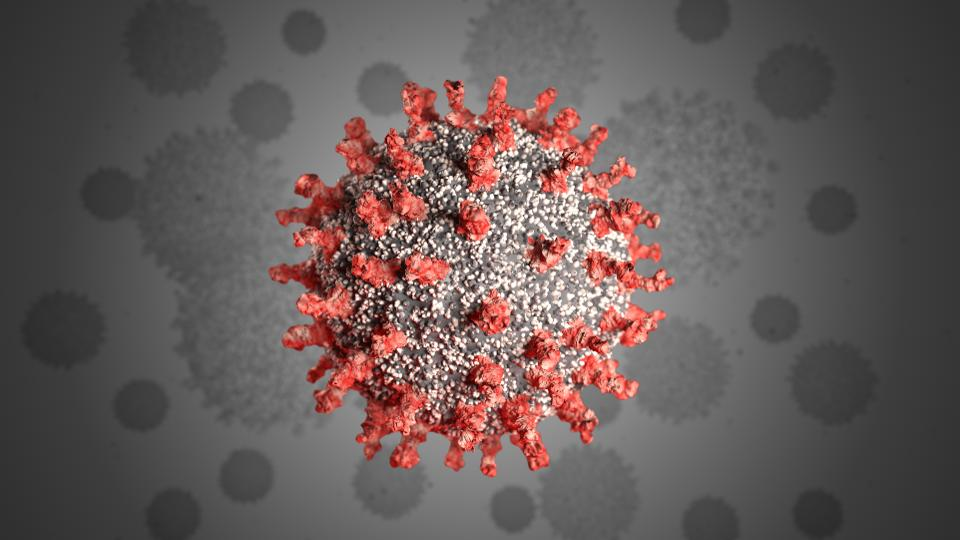

In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import requests
import logging
import json
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import time
from bs4 import BeautifulSoup
from config import vantage_key, census_key, bls_key
import asyncio
import aiohttp
import nest_asyncio
import numpy as np
import folium
import folium.plugins as plugins
from folium.plugins import HeatMap
import random
from scipy import stats

In [2]:
# logging.basicConfig(format='%(asctime)s : %(lineno)d : %(levelname)s : %(message)s', level=logging.DEBUG)

## This section of code is where we brought in our initial data via 500 calls to Alpha Vantage, 2 Calls to Census data, 50+ calls to Bureau of Labor Statistics, created and pulled from 10+ CSV files and webscraped from Wikipedia. To make the data more friendly to time series data, we applied a Lambda function to convert the date column into a proper datetime format.

In [3]:
#Create covid dataframe
covid_response = requests.get("https://covidtracking.com/api/states/daily").json()
covid_dataframe = pd.DataFrame(covid_response)
covid_dataframe['date'] = covid_dataframe['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d')) 
covid_dataframe.head(3)

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,2020-05-15,AK,388.0,32030.0,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,32418,32418,32418,02,0.0,0.0,655.0,1.0,656.0
1,2020-05-15,AL,11216.0,134847.0,NaN,NaN,1377.0,NaN,497.0,NaN,...,1377.0,146063,146063,146063,01,9.0,27.0,3830.0,248.0,4078.0
2,2020-05-15,AR,4463.0,77066.0,NaN,65.0,520.0,NaN,NaN,9.0,...,520.0,81529,81529,81529,05,1.0,11.0,5484.0,227.0,5711.0


## In this section, we pulled in a list of the S&P 500 data as well as industry categories. To do that, we pulled it in from Wikipedia using BeautifulSoup 4. The data was pulled in using a get request, isolating the table data, and pulling the ‘th’ and ‘td’ content into entrylist.

In [4]:
#Scrapes Wikipedia Table for S&P 500 data
wikipedia_response = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies").text
soup = BeautifulSoup(wikipedia_response,'lxml')
wiki_table = soup.find('table',{'class':'wikitable sortable'})

#This creates a list with the names of the headers
headerslist = []
headers = wiki_table.findAll('th')
for head in headers:
    headerslist.append(head.text)

#This adds the content to a list    
content = wiki_table.findAll('td')
dataframelist = []
entrylist = []
while (content):
    if len(entrylist) < 9:
        contentvalue = content.pop(0).text
        entrylist.append(contentvalue)
    else:
        dataframelist.append(entrylist)
        entrylist = []


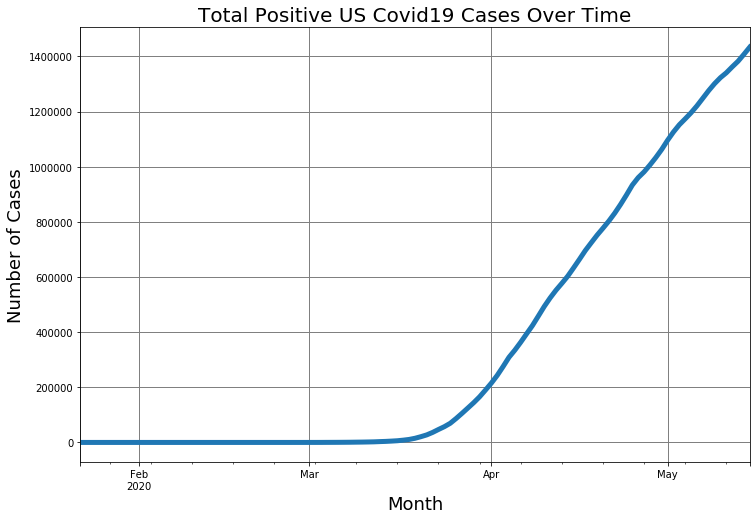

In [5]:
groupedDF = covid_dataframe.groupby(['date'])
positiveseries = groupedDF['positive'].sum()
positiveseries.plot(figsize=(12,8), linewidth=5, legend=False)
plt.grid(color="gray", linestyle='-', linewidth=1)
plt.title("Total Positive US Covid19 Cases Over Time", fontsize=20)
plt.ylabel("Number of Cases", fontsize=18)
plt.xlabel("Month", fontsize=18)
plt.show()

In [6]:
#This creates the S&P dataframe and formats the datetime row
sp500DF = pd.DataFrame(dataframelist, columns=headerslist)
sp500DF['Symbol\n'] = sp500DF['Symbol\n'].str[0:-1]
sp500DF['Founded\n'] = sp500DF['Founded\n'].str[0:-1]
sp500DF['Date first added'] = pd.to_datetime(sp500DF['Date first added'], infer_datetime_format = True, errors='coerce')
sp500DF = sp500DF.rename(columns={'Symbol\n':'Symbol','Founded\n':'Founded'})
# sp500DF

In [7]:
#This joins the industries csv to the sp500 DF
industriesDF = pd.read_csv("Industries.csv")
industriesDF = pd.merge(sp500DF, industriesDF, how='left', left_on="GICS Sub Industry", right_on="GICS Codes/ Sub-industries")
industriesDF = industriesDF[['Symbol', 'Security', 'GICS Sector', 'GICS Sub Industry', 'Headquarters Location', 'Date first added', 'GICS Codes/ Sub-industries', 'NAICS']]
industriesDF.head(3)

,Symbol,Security,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,GICS Codes/ Sub-industries,NAICS
0,MMM,3M Company,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,Industrial Conglomerates,Manufacturing
1,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,Health Care Equipment,Health care and social assistance
2,ABBV,AbbVie Inc.,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,Pharmaceuticals,Health care and social assistance


## In this section, we pull in stock data for the past 100 days of each stock listed in the S&P 500. Given that it took a significant amount of time to do this, we leveraged asyncio, which is a python library that supports asynchronous processing. This brought the API time down from 10-20 minutes to a handful of seconds.

In [8]:
#This pulls S&P data from the Alpha Vantage API
#Note that the S&P changes throughout the year
#Also, we're getting the past 100 days on a rolling basis

ticker_list = list(sp500DF['Symbol'].values)

completeurls = [] # completed urls go here

# stockDF = pd.DataFrame(columns=list(stockDF.columns.values))
stockdata = []

# This generates all URLs and places them in a list so that async can create futures out of them
for stocks in ticker_list:
    completeurls.append(f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stocks}&outputsize=compact&apikey={vantage_key}")

nest_asyncio.apply()
async def get_stocks(url):
    connector = aiohttp.TCPConnector(limit=10)
    async with aiohttp.ClientSession(connector=connector, raise_for_status=True) as session:
        async with session.get(url) as response:
            response_content = await response.json()
            response_content['Time Series (Daily)']['symbol'] = url.split("&")[1].split('=')[1] #This extracts the symbol from the URL
            return stockdata.append(response_content['Time Series (Daily)'])

#set up the event loop
asyncio.set_event_loop(asyncio.new_event_loop())
loop = asyncio.get_event_loop()

#add tasks to run
tasks = []
for urls in completeurls:
    future = asyncio.ensure_future(get_stocks(urls))
    tasks.append(future)


#Run
loop.run_until_complete(asyncio.wait(tasks))
# loop.close()


({<Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> exception=KeyError('Time Series (Daily)')>,
  <Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> result=None>,
  <Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> result=None>,
  <Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> result=None>,
  <Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> result=None>,
  <Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> result=None>,
  <Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> result=None>,
  <Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> result=None>,
  <Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> result=None>,
  <Task finished coro=<get_stocks() done, defined at

## To make the stock data useful, we had to take data which was a series of nested dictionaries and turn it into something usable. We found that an easy way to do this was to normalize the data using a module within pandas called json_normalize, which basically takes nested dictionaries and transforms them to fit nicely in a dataframe.
#### example `json_normalize`

In [9]:
#This creates the final stockdata dataframe
stockdata = json_normalize(stockdata)
stockDF = pd.DataFrame(stockdata)
stockDF = stockDF.set_index(['symbol'])
stockDF = stockDF.filter(regex='close')
stockDF.head(3)

,2020-05-15.4. close,2020-05-14.4. close,2020-05-13.4. close,2020-05-12.4. close,2020-05-11.4. close,2020-05-08.4. close,2020-05-07.4. close,2020-05-06.4. close,2020-05-05.4. close,2020-05-04.4. close,...,2020-01-07.4. close,2020-01-06.4. close,2020-01-03.4. close,2020-01-02.4. close,2019-12-31.4. close,2019-12-30.4. close,2019-12-27.4. close,2019-12-26.4. close,2019-12-24.4. close,2019-12-23.4. close
symbol,,,,,,,,,,,,,,,,,,,,,
ACN,183.8800,179.9900,181.0000,185.7200,187.7500,188.5600,187.1100,180.3800,181.6200,179.5300,...,203.9300,208.4300,209.8000,210.1500,210.5700,210.6400,212.2200,212.0500,211.6100,210.8300
ALXN,101.9400,100.9200,102.4500,101.6500,101.3400,97.3400,96.9200,96.8400,98.2500,103.8400,...,106.8500,106.5800,106.4100,107.8400,108.1500,107.3400,108.5500,108.9300,110.2800,110.4600
ABT,89.8900,91.7800,92.1600,93.8000,96.0700,93.7000,93.9900,91.0800,93.0300,89.8300,...,85.8600,86.3400,85.8900,86.9500,86.8600,86.8000,87.4000,87.2800,87.2800,87.3500


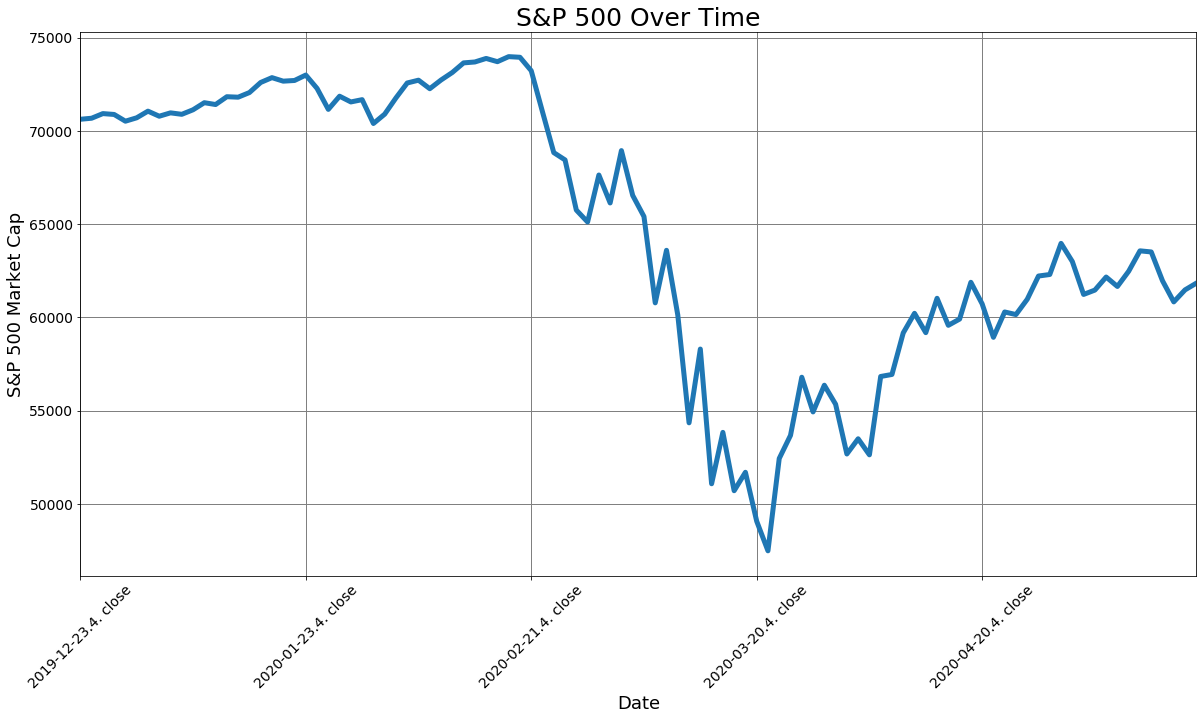

In [10]:
#This creates the final stockdata dataframe
stockDF = stockDF.apply(pd.to_numeric)
stock_visual = stockDF.sum()
stock_visual = stock_visual.sort_index(ascending=True)
stock_visual.plot(figsize=(20,10), linewidth=5, legend=False, fontsize=14)
plt.grid(color="gray", linestyle='-', linewidth=1)
plt.title("S&P 500 Over Time", fontsize=25)
plt.ylabel("S&P 500 Market Cap", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.xticks(rotation=45)
plt.show()

# <font color=red>Correlation Coefficient </font>
***

In [11]:
corcoefficient = stats.pearsonr(list(positiveseries.iloc[15:].values),list(stock_visual.values))
corcoefficient #and P value

(-0.5619241857897661, 1.1798740691398032e-09)

## For this section, we aggregated and joined 2018 and 2019 population data by state and working population. Our hope was that we could use this to drill into the primary industries by state and see how Covid-19 affected those states based on their predominant industries. We even worked to match the industry codes (GICS and NAICS). However, we ran out of time. This was generally clean data and only required a small amount of cleaning and manipulation. 


In [12]:
#2019 Population data - US Census Bureau
census_response = requests.get(f"https://api.census.gov/data/2019/pep/population?get=COUNTY,DATE_CODE,DATE_DESC,DENSITY,POP,NAME,STATE&for=state:*&key={census_key}").json()
census_headers = census_response.pop(0)
populationDF = pd.DataFrame(census_response, columns = census_headers)
populationDF = populationDF[populationDF['DATE_CODE']=='12']
populationDF = populationDF[['DENSITY','POP','NAME','STATE']]
# populationDF

#This is 2018 population data
census_response2 = requests.get(f"https://api.census.gov/data/2018/pep/population?get=COUNTY,DATE_CODE,DATE_DESC,DENSITY,POP,STATE&for=state:*&key={census_key}").json()
census_headers2 = census_response2.pop(0)
populationDF2 = pd.DataFrame(census_response2, columns = census_headers2)
populationDF2 = populationDF2[populationDF2['DATE_CODE']=='11']
populationDF2 = populationDF2[['DENSITY','POP','STATE']]
# populationDF2

# total jobs 2018 - from bureau of economic analysis (https://apps.bea.gov/iTable/iTable.cfm?reqid=70&step=1&isuri=1)
empByIndDF = pd.read_csv("totalEmpIndustry2018.csv")
workers_by_indDF = pd.read_csv("totaljobs2018.csv")

#Create master Dataframe for 2018 data
populationDF = pd.merge(populationDF, populationDF2, how='left', on="STATE", suffixes=['_2019','_2018'])
master_industryDF = pd.merge(empByIndDF, populationDF, right_on='NAME', left_on='GeoName', how='left')
master_industryDF = pd.merge(master_industryDF, workers_by_indDF, left_on='NAME', right_on='GeoName', how='left')
master_industryDF = master_industryDF[['NAME','STATE','LineCode','Description','2018_x','2018_y','POP_2018','POP_2019']]
master_industryDF = master_industryDF.rename(columns={'2018_x':'2018 Workers In Industry',
                                                      '2018_y':'2018 Working Pop',
                                                      'POP_2019':'2019 Overall Population',
                                                      'POP_2018':'2018 Overall Population',
                                                     })

#Imports state list and attaches the abbreviation
stateDF = pd.read_csv("stateabbrs.csv")
master_industryDF = pd.merge(master_industryDF, stateDF, how='left', left_on="NAME", right_on="State")
master_industryDF = master_industryDF[['NAME',
                                       'Code',
                                       'STATE',
                                       'LineCode',
                                       'Description',
                                       '2018 Workers In Industry',
                                       '2018 Working Pop',
                                       '2018 Overall Population',
                                       '2019 Overall Population'
                                       ]]
master_industryDF['2018 Overall Population'] = pd.to_numeric(master_industryDF['2018 Overall Population'])
master_industryDF['2019 Overall Population'] = pd.to_numeric(master_industryDF['2019 Overall Population'])
master_industryDF['2018 Workers In Industry'] = pd.to_numeric(master_industryDF['2018 Workers In Industry'], errors='coerce')
master_industryDF = master_industryDF.dropna(subset=['2018 Workers In Industry']) #This dropped Delaware's logging industry entry. Not sure of the downstream effects
master_industryDF['2018 Percentage of Working Pop'] = (master_industryDF['2018 Workers In Industry'].astype('int64') / master_industryDF['2018 Working Pop']) * 100
# master_industryDF['2019 Working Pop'] = round(master_industryDF['2019 Overall Population'] * (master_industryDF['2018 Percentage of Working Pop'] / 100),0) 
master_industryDF

,NAME,Code,STATE,LineCode,Description,2018 Workers In Industry,2018 Working Pop,2018 Overall Population,2019 Overall Population,2018 Percentage of Working Pop
0,Alabama,AL,01,70,Farm employment,42220.0,2691517,4887871,4903185,1.568632
1,Alabama,AL,01,100,"Forestry, fishing, and related activities",15895.0,2691517,4887871,4903185,0.590559
2,Alabama,AL,01,200,"Mining, quarrying, and oil and gas extra...",10560.0,2691517,4887871,4903185,0.392344
3,Alabama,AL,01,300,Utilities,14176.0,2691517,4887871,4903185,0.526692
4,Alabama,AL,01,400,Construction,148326.0,2691517,4887871,4903185,5.510870
...,...,...,...,...,...,...,...,...,...,...
1066,Wyoming,WY,56,1600,Health care and social assistance,30617.0,405010,577737,578759,7.559566
1067,Wyoming,WY,56,1700,"Arts, entertainment, and recreation",8255.0,405010,577737,578759,2.038221
1068,Wyoming,WY,56,1800,Accommodation and food services,35917.0,405010,577737,578759,8.868176
1069,Wyoming,WY,56,1900,Other services (except government and go...,17920.0,405010,577737,578759,4.424582


## The most difficult part of this data was finding what codes we needed to find unemployment rates by state. Once this was accomplished, it was a matter of setting up a loop to pull in each state. There are problems with the last 3 endpoints, which are Puerto Rico, Wyoming and Wisconsin. More generally, this data set really needed to have data for April to be useful, since we know that April was the month where the unemployment rate began to spike.


In [ ]:
# US Bureau of Labor Statistics - Returns unadjusted unemployment rates
areaCodesDF = pd.read_csv("bureauoflaborstats.csv")
fips_dict = pd.read_csv("fipscodes.csv")
fips_dict = fips_dict[["State Abbreviation","FIPS Code"]]
fips_dict = fips_dict.to_dict()

#If we want to get more granular, we can switch the area_type_code from A to N
areaCodesList = areaCodesDF[areaCodesDF["area_type_code"]=="A"]
areaCodesList = list(areaCodesList["area_code"].values)

master_unemp_DF = pd.DataFrame({"year":[],"periodName":[],"value":[],"state":[]})

for x in areaCodesList:
    try:
        seriesid = f"LAU{x}03"
        fips_code = x[2:4]
        headers = {'Content-type': 'application/json'} 
        logging.debug(f"RETRIEVING: {x}, {fips_code}")
        data = json.dumps({"seriesid": [seriesid],"startyear":"2010", "endyear":"2020","registrationkey":bls_key})
        response = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers).json()
        state_unemp_DF = pd.DataFrame(response['Results']['series'][0]['data'])
        state_unemp_DF['state'] = fips_dict['State Abbreviation'][int(fips_code)]
        state_unemp_DF = state_unemp_DF[["year","periodName","value","state"]]
        state_unemp_DF['value'] = state_unemp_DF['value'].astype('float')
        master_unemp_DF = master_unemp_DF.append(state_unemp_DF)
    except:
        logging.error(f"Error retrieving data: {x}")


ERROR:root:Error retrieving data: ST0100000000000
ERROR:root:Error retrieving data: ST0200000000000


In [ ]:
master_unemp_DF

# It would be hard to plot this DataFrame because it is populated live and reran everytime to test the data.

## In this section we cleaned up the unemployment dataframe to plot the graphs. We graphed unemployment over time for all 50 states and isolated 10 states that we picked at random as a group.

In [ ]:
# Pull just the 2020 info from the DataFrame
msx = master_unemp_DF[master_unemp_DF["year"] == "2020"]

# Remove the empty data from the DataFrame (NaN) and apply lambda for dates
msx_cleaned = msx[msx["value"] != "nan"]
msx_cleaned['periodName']  = msx_cleaned['periodName'].apply(lambda x: time.strptime(x, '%B').tm_mon)

# Sort and rename columns
msx_cleaned = msx_cleaned.rename(columns={'periodName':'month'})
msx_cleaned.sort_values(by=["state","month"])


In [ ]:
# This is the total US employment rate for 2020 in January, February, and March. 
# We would have liked to capture May.

#msx_cleaned.plot()

# Grouped the DataFrame by month.
msxgroupedDF = msx_cleaned.groupby(['month'])
msxAVG = msxgroupedDF['value'].mean()
msxAVG.plot(figsize=(20,10), linewidth=5, legend=False)

# Had to rearrage the data so the line graph made sense. 
locs, labels = plt.xticks() 
plt.xticks([1,2,3], ['January', 'February', 'March']) 

plt.title("US Unemployment Over Time (2020)", fontsize=25)
plt.ylabel("Unemployment Rate", fontsize=18)
plt.xlabel("Month", fontsize=18)
plt.show()
#fig.savefig('Unemployment_line.png')



In [ ]:
# Took the clean US unemployment rates and pulled out the states.
msxSelectStates = msx_cleaned[msx_cleaned["state"].isin(["NY", "VA", "MD", "FL", "MI", "NV", "TX", "WA", "CA", "HI"])]

# msxSelectStates.groupby('state').plot(x='month', y='value', legend=True, title = "state")

In [ ]:
# Set states as a variable
states = ["NY", "VA", "MD", "FL", "MI", "NV", "TX", "WA", "CA", "HI"]

# Loop through the states to plot multiple line graphs
for state in states:
    msxSelectStates1 = msx_cleaned[msx_cleaned["state"] == state]
    msxSelectStates1.groupby('state').plot(x='month', y='value', legend=False, title = state)
    locs, labels = plt.xticks() 
    plt.xticks([1,2,3], ['January', 'February', 'March']) 
    plt.ylabel("unemployment rate")
    plt.xlabel("Month")
    plt.show()
    

## Which State was most affected in March?

In [ ]:
# Took the clean unemployment DataFrame and isolated data by March.
# We see Idaho had the lowest unemployment. New Hampshire the highest. 

msx_cleaned[msx_cleaned['month']==3].sort_values("value").plot.bar(x='state', y='value', fontsize=14, legend=False, figsize=(20,10)).grid(axis='y')
plt.ylabel("Unemployment Rate", fontsize=20)
plt.xlabel("States", fontsize=20)
plt.title("US Unemployment Rate March", fontsize=25)
#fig.savefig('Unemployment_graph.png')

In [ ]:
# The group wanted to look at 10 states.
# We see Maryland had the highest unemployment rate in March 2020.

states = ["NY", "VA", "MD", "FL", "MI", "NV", "TX", "WA", "CA", "HI"]
msx_finalmonth = msx_cleaned[msx_cleaned['month']==3].sort_values("value")
msx_finalmonth[msx_finalmonth["state"].isin(states)].plot.bar(x='state', y='value', fontsize=20, legend=False, figsize=(20,10)).grid(axis='y')
plt.xlabel("States", fontsize=18)
plt.ylabel("Unemployement Rate", fontsize=18)
plt.title("Unemployment Rate Across Sample States for March (2020)", fontsize=20)
#fig.savefig('graph.png')

# Charting the effects of Covid-19:
***
## Key Questions:
1. Correlation between Covid & S&P.
2. Correlation between covid & unemployment.
3. States that were affected the most.
4. Industries that were affected the most* ## Where do you get data: 
***
### What can be visualized through geocoding tools? How do you represent the data? 
We found data through CSV and API at https://covidtracking.com, and got to work finding ways to plot it. I tried four different tools before I was able to get a "working" map up and running to share with the team.

My first attempt was with Cesiumpy and CesiumJS, I had used them before and felt it might be easier to just go with what I was familiar with and could get going in the fastest time. Cesiumpy looked really promising because it was built in python and seemed to fit right in Jupyter notebooks or lab, see link for details [https://cesiumpy.readthedocs.io/en/latest/basics.html#display-cesium-widget ] but after multiple days and countless attempts I only got a basic html map to render with no data and had to look for a "working" solution. CesiumJS, this was still cesium just better right? No, CesiumJS was more days wasted and still no map. I started to go down the road of a local install, but realized my team would not be able to easily use it, so I thought "Docker images" might work, and wasted another day installing prototype Windows 10, just to find that the Docker images available were also too much of a time investment because they too didn't work.

Okay back to the drawing board. I needed something easy, reliable, and integrated with our IDE (Jupyter). Geopandas and ileaftlet, but just as I started to look into these, I found Folium and it was like Magic! Within a few hours I was able to not only get a map up but also have some content plotting in a heat-map... YES!!! It was not all easy, and I still took several development roads that lead to broken code but Folium is where it's at! They even have notebook examples you can download and try out.
* ## Folium [https://pypi.org/project/folium/]
* Examples: https://nbviewer.jupyter.org/github/python-visualization/folium/tree/master/examples/       
 

In [ ]:
# Start by reading in my data CSV and displaying the calumn headers
covid_dataframe = pd.read_csv('spread_hist_by_state.csv')
print(covid_dataframe.columns.tolist())

In [ ]:
covid_data = covid_dataframe[['date', 'state', 'death', 'positive', 'negative','recovered', 'dataQualityGrade', 'lastUpdateEt']].loc[covid_dataframe['dataQualityGrade'] != 'F']
covid_data.head(3)

state_geo_df = pd.read_csv('state_latlong.csv')
covid_df = pd.merge(covid_data, state_geo_df, how='left', left_on="state", right_on='state')

plot_df = covid_df[['latitude','longitude','death','date','positive', 'negative', 'state', 'recovered']].sort_values(by='date', axis=0, ascending=True).fillna(0)
# print any outlayers with blank coordinates
#print(plot_df.loc[plot_df['latitude'] == 0]['state'].unique())
plot_df.head(2)

## Set up the map layers

In [ ]:
# sets up a dictionary to organize elements related to map layers 
layer_types = [{'title' : 'Covid : Tested Positive',
                'status' : 'positive',
                'show' : True,
                'plot_data' : [],
                'gr_val' : [.2,.9,.3],
                'gr_clr' : ['red','orange','red'],
                'rad' : 1.5,
                'fps' : 5
               },
               {'title' : 'Covid : Tested Negative',
                'status' : 'negative',
                'show' : False,
                'plot_data' : [],
                'gr_val' : [.9,.3,.3],
                'gr_clr' : ['green','yellow','lime'],
                'rad' : 1,
                'fps' : 5
               },
               {'title' : 'Covid : Recovered',
                'status' : 'recovered',
                'show' : False,
                'plot_data' : [],
                'gr_val' : [.5,.5,.5],
                'gr_clr' : ['blue','blue','blue'],
                'rad' : 1,
                'fps' : 5
               },
               {'title' : 'Covid : Deaths',
                'status' : 'death',
                'show' : False,
                'plot_data' : [],
                'gr_val' : [1,1,0],
                'gr_clr' : ['rgb(0,0,0)','rgb(0,0,0)','rgb(255,0,0)'],
                'rad' : .5,
                'fps' : 5
               }]

## Process dataframes into lists the hardway (the stupid way)

In [ ]:
date_indx = []

for date_stp in plot_df['date'].unique():
    
    # set up the data index by splitting the date into its parts and using datatime function to reassemble it into a datatiem object *(not really needed just yet)
    dt = str(date_stp)
    y, m, d = int(dt[:4]), int(dt[4:6]), int(dt[6:])
    date_indx.append(datetime(y,m,d).strftime("%Y-%m-%d"))  
    
    # use loc to pull all data for each day to match the index across the four layers  
    heat_df = plot_df.loc[plot_df['date'] == date_stp].dropna(axis=0, subset=['latitude', 'longitude', 'death', 'positive', 'negative', 'recovered', 'date'])

    # setup temp lists to hold data for each day to be added to the layer_types dict afterward
    heat_data_pos_date, heat_data_neg_date, heat_data_rec_date, heat_data_dth_date = [], [], [], []
    
    #loop over the heat_df dataframe using tuples to access the rows
    #  (there is cleaner way to load list right into Folium, but errors keep getting in the way, so brut force is the fallback)
    for row in heat_df.itertuples():
        pos_magna = int(row.positive)
        neg_magna = int(row.negative)
        rec_magna = int(row.recovered)
        dth_magna = int(row.death)

        if pos_magna > 0:
            heat_point = [row.latitude * random.uniform(1.001,1.01), row.longitude * random.uniform(1.001,1.01), 1]
            heat_data_pos_date.append(heat_point)
        if neg_magna > 0:
            heat_point = [row.latitude, row.longitude, 1]
            heat_data_neg_date.append(heat_point) 
        if rec_magna > 0:
            heat_point = [row.latitude, row.longitude, 1]
            heat_data_rec_date.append(heat_point)
        if dth_magna > 0:
            heat_point = [row.latitude, row.longitude, 1]
            heat_data_dth_date.append(heat_point)

    #print(f'heat_data_pos_date [{heat_data_pos_date}]')
    
    # push data lists into the layer_types dict
    layer_types[0]['plot_data'].append(heat_data_pos_date)
    layer_types[1]['plot_data'].append(heat_data_neg_date)
    layer_types[2]['plot_data'].append(heat_data_rec_date)
    layer_types[3]['plot_data'].append(heat_data_dth_date)

# Print below to ensure the index lenth matches the data list lenth     
#print(f'layer_types[0]["plot_data"] [{len(layer_types[0]["plot_data"])}] date_indx [{len(date_indx)}]')
#print(f'layer_types[0]["plot_data"] \n{"--"* 40}\n[{layer_types[0]["plot_data"]}]')

## Build the map

In [ ]:
main_map = folium.Map(
    [plot_df['latitude'].mean(),plot_df['longitude'].mean()],
    tiles='stamentoner',
    zoom_start=4,
    max_opacity=0.9,
    blur=4
)

layer_control = folium.LayerControl(collapsed=True)

# loop over layer_types dict to build each map layer
for layer_type in layer_types:

    # this holds 
    map_Feature_Group = folium.FeatureGroup(name=layer_type['title'], show=layer_type['show'])
    layer_control.add_child(map_Feature_Group)

    Heat_mapw_time = plugins.HeatMapWithTime(
        data = layer_type['plot_data'],
        index = date_indx,
        auto_play = True,
        use_local_extrema = True,
        radius = layer_type['rad'],
        min_opacity = 0.5,
        speed_step = 2,
        min_speed = layer_type['fps'],
        scale_radius = True,
        name = layer_type['title'],
        gradient={layer_type['gr_val'][0]: layer_type['gr_clr'][0],
                  layer_type['gr_val'][1]: layer_type['gr_clr'][1],
                  layer_type['gr_val'][2]: layer_type['gr_clr'][2]}
    )

    main_map.add_child(Heat_mapw_time)

# add the layer control
layer_control.add_to(main_map)

## Done!!!

In [ ]:
# and.... display the map!!!
main_map